In [1]:
# =========================
# Assignment 3: DQN for Pong
# Modular Expert Notebook
# =========================

# 1. Imports and Seed Settings
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import ale_py
import random
from collections import deque
import matplotlib.pyplot as plt
from assignment3_utils import img_crop, downsample, to_grayscale, normalize_grayscale, transform_reward

# Seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:

# =========================
# 2. Environment Setup
# =========================
image_shape = (84, 80)  # Height x Width for preprocessing

def make_env():
    """Create Pong environment with RGB frames."""
    try:
        env = gym.make('ALE/Pong-v5', render_mode='rgb_array')
    except Exception:
        env = gym.make('Pong-v4', render_mode='rgb_array')
    return env

env = make_env()

In [3]:
# =========================
# 3. Frame Preprocessing
# =========================
def preprocess_frame(img: np.ndarray, image_shape: tuple) -> np.ndarray:
    """Process the frame: crop, downsample, grayscale, normalize."""
    img = img_crop(img)
    img = downsample(img)
    img = to_grayscale(img)
    img = normalize_grayscale(img)
    return img.reshape(image_shape[0], image_shape[1])  # Return 2D array

def get_initial_state(env, image_shape):
    """Stack 4 identical preprocessed frames as initial state."""
    obs, _ = env.reset()
    processed = preprocess_frame(obs, image_shape)
    return np.stack([processed] * 4, axis=0)  # Shape: (4, 84, 80)

print(f"Initial state shape: {get_initial_state(env, image_shape).shape}")

Initial state shape: (4, 84, 80)


In [4]:
# =========================
# 4. DQN CNN Model
# =========================
class DQNCNN(nn.Module):
    """Deep Q-Network with convolution layers."""
    def __init__(self, input_channels: int, n_actions: int):
        super(DQNCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU()
        )
        conv_w = self._conv2d_size_out(self._conv2d_size_out(self._conv2d_size_out(image_shape[1], 8, 4), 4, 2), 3, 1)
        conv_h = self._conv2d_size_out(self._conv2d_size_out(self._conv2d_size_out(image_shape[0], 8, 4), 4, 2), 3, 1)
        linear_input_size = conv_w * conv_h * 64
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _conv2d_size_out(self, size, kernel_size, stride, padding=0):
        return (size - kernel_size + 2*padding) // stride + 1

    def forward(self, x: torch.Tensor):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [5]:

# =========================
# 5. Replay Buffer
# =========================
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    def __init__(self, capacity: int = 100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        """Randomly sample a batch of experiences."""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [6]:
# =========================
# 6. Epsilon-Greedy Policy
# =========================
def epsilon_greedy(state: np.ndarray, model: nn.Module, epsilon: float, n_actions: int) -> int:
    """Select action using epsilon-greedy policy."""
    if random.random() < epsilon:
        return random.randrange(n_actions)
    state_t = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = model(state_t)
        return q_values.max(1)[1].item()

In [7]:
# =========================
# 7. Training Function
# =========================
def train_dqn(
    env,
    policy_net,
    target_net,
    optimizer,
    buffer: ReplayBuffer,
    image_shape,
    num_episodes=500,
    batch_size=8,
    target_update=10,
    gamma=0.95,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995
):
    """Train DQN agent."""
    epsilon = eps_start
    n_actions = env.action_space.n
    rewards_per_episode = []
    avg_rewards = []

    for episode in range(num_episodes):
        state = get_initial_state(env, image_shape)
        done = False
        total_reward = 0

        while not done:
            action = epsilon_greedy(state, policy_net, epsilon, n_actions)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            processed = preprocess_frame(obs, image_shape)
            next_state = np.append(state[1:], np.expand_dims(processed, 0), axis=0)

            # Transform reward for stability
            buffer.push(state, action, transform_reward(reward), next_state, done)
            state = next_state
            total_reward += reward

            # Training step
            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)

                states_v = torch.tensor(states, dtype=torch.float32).to(device)
                next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
                actions_v = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards_v = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                dones_v = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                # Compute Q values and target
                q_vals = policy_net(states_v).gather(1, actions_v)
                next_q_vals = target_net(next_states_v).max(1)[0].unsqueeze(1).detach()
                q_targets = rewards_v + gamma * next_q_vals * (1 - dones_v)

                loss = nn.MSELoss()(q_vals, q_targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            epsilon = max(epsilon * eps_decay, eps_end)

        # Update target network
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards_per_episode.append(total_reward)
        avg5 = np.mean(rewards_per_episode[-5:])
        avg_rewards.append(avg5)

        if episode % 10 == 0:
            print(f"Episode {episode} | Reward: {total_reward} | Avg5: {avg5:.2f} | Epsilon: {epsilon:.2f}")

    return rewards_per_episode, avg_rewards


Running config: batch_size=8 | target_update=10
Episode 0 | Reward: -21.0 | Avg5: -21.00 | Epsilon: 0.05


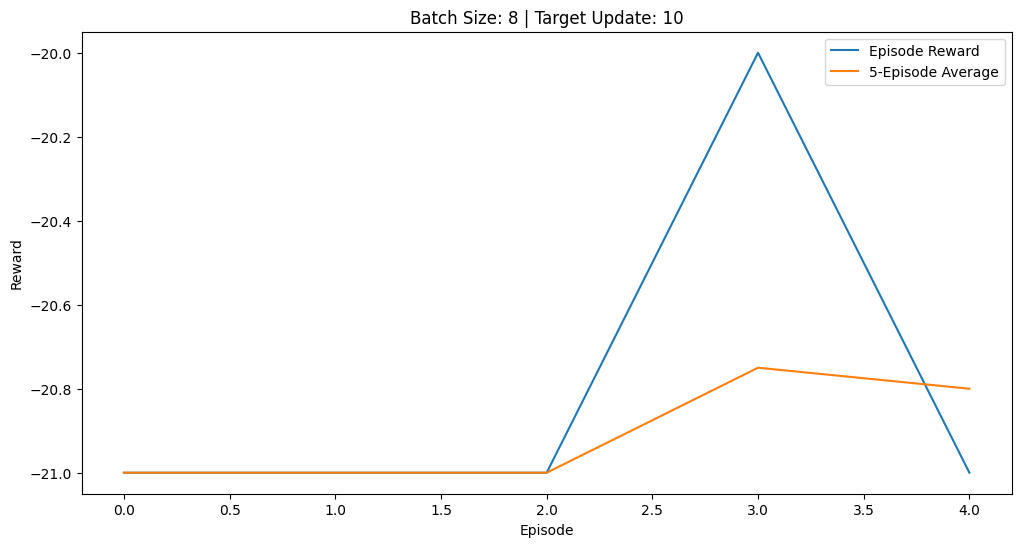


Running config: batch_size=16 | target_update=10
Episode 0 | Reward: -21.0 | Avg5: -21.00 | Epsilon: 0.05


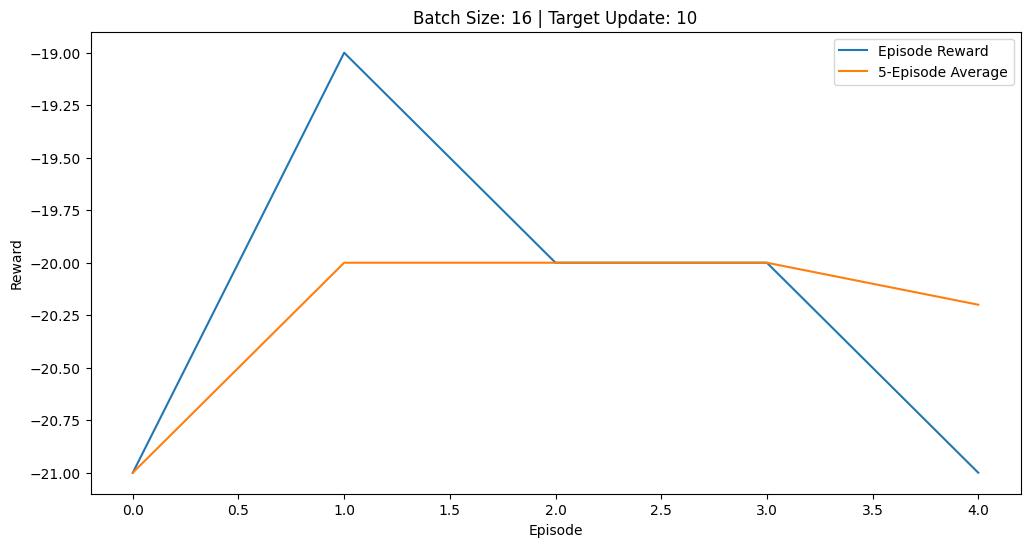


Running config: batch_size=8 | target_update=3
Episode 0 | Reward: -21.0 | Avg5: -21.00 | Epsilon: 0.05


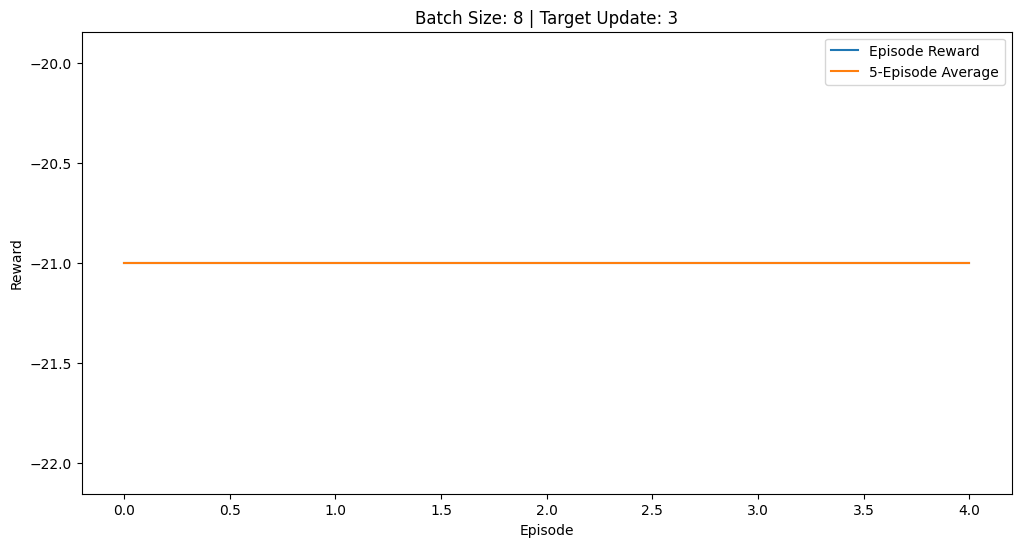


Running config: batch_size=16 | target_update=3
Episode 0 | Reward: -21.0 | Avg5: -21.00 | Epsilon: 0.05


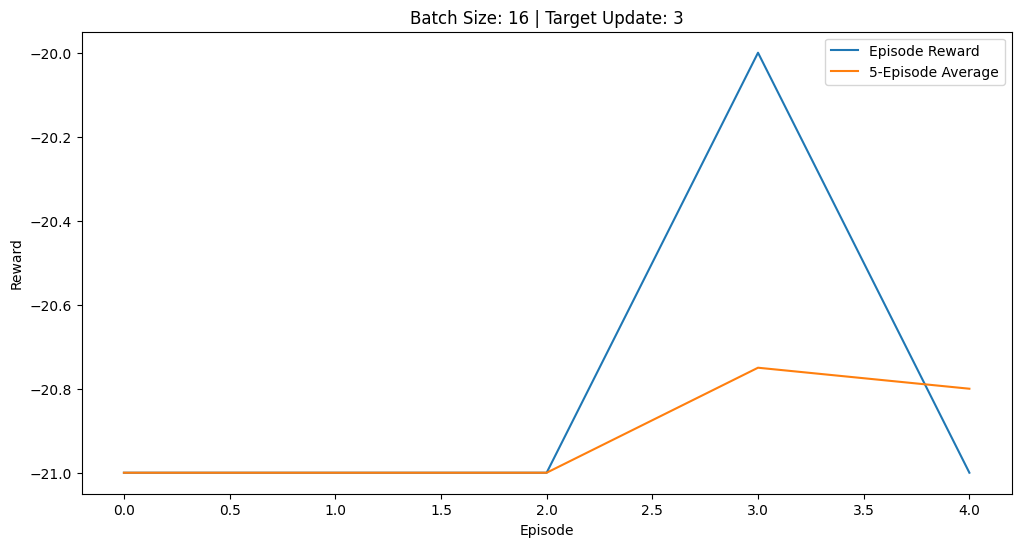

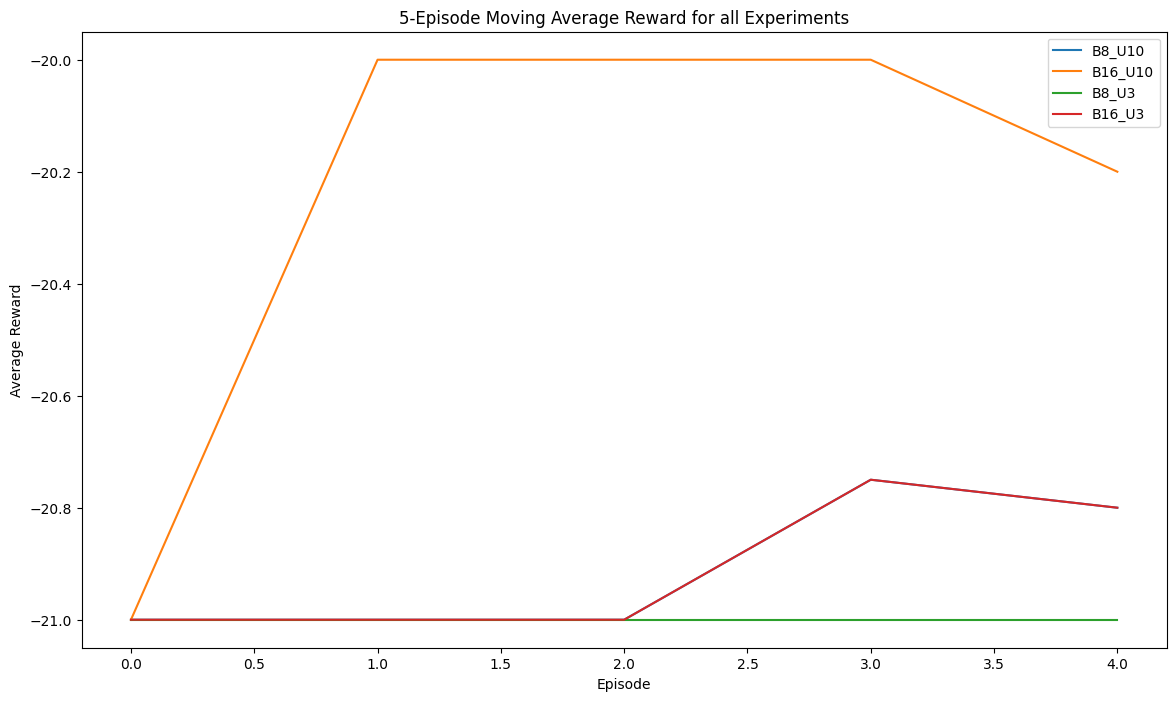

In [14]:


# =========================
# 8. Experiment Runner
# =========================
def run_experiments():
    """Run experiments with different batch sizes and target network update frequencies."""
    configs = [
        {"batch_size": 8, "target_update": 10},
        {"batch_size": 16, "target_update": 10},
        {"batch_size": 8, "target_update": 3},
        {"batch_size": 16, "target_update": 3},
    ]
    num_episodes = 5
    all_results = []

    for config in configs:
        print(f"\nRunning config: batch_size={config['batch_size']} | target_update={config['target_update']}")
        policy_net = DQNCNN(4, env.action_space.n).to(device)
        target_net = DQNCNN(4, env.action_space.n).to(device)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
        buffer = ReplayBuffer()

        rewards, avg_rewards = train_dqn(
            env, policy_net, target_net, optimizer, buffer, image_shape,
            num_episodes=num_episodes,
            batch_size=config['batch_size'],
            target_update=config['target_update']
        )

        all_results.append((config, rewards, avg_rewards))

        # Plot per configuration
        plt.figure(figsize=(12,6))
        plt.plot(rewards, label='Episode Reward')
        plt.plot(avg_rewards, label='5-Episode Average')
        plt.title(f"Batch Size: {config['batch_size']} | Target Update: {config['target_update']}")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.show()

    # Combined plot
    plt.figure(figsize=(14,8))
    for config, _, avg_rewards in all_results:
        label = f"B{config['batch_size']}_U{config['target_update']}"
        plt.plot(avg_rewards, label=label)
    plt.title("5-Episode Moving Average Reward for all Experiments")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.show()


# =========================
# Uncomment to run experiments
# =========================
run_experiments()